In [44]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Masking, TimeDistributed, Dropout
from tensorflow.keras import mixed_precision
import shap
from sklearn.inspection import permutation_importance
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras import backend as K
import seaborn as sns

operating_system ='mac'
if operating_system == 'win':
    path = f'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    path = f'/Users/fabienaugsburger/Documents/GitHub/master-project/'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
#import the X and y data in the format .npy
dataset = 'X_y_EU_1h'

X_train = np.load(f'{path}DATASETS/{dataset}/X_train.npy')
y_train = np.load(f'{path}DATASETS/{dataset}/y_train.npy')
X_test = np.load(f'{path}DATASETS/{dataset}/X_test.npy')
y_test = np.load(f'{path}DATASETS/{dataset}/y_test.npy')
X_validation = np.load(f'{path}DATASETS/{dataset}/X_validation.npy')
y_validation = np.load(f'{path}DATASETS/{dataset}/y_validation.npy')

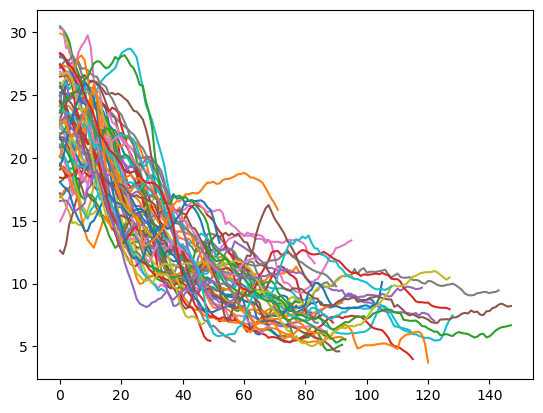

148 14 76.29230769230769


In [18]:
storms = range(65)
for storm in storms:
    plt.plot(y_train[storm,:])
plt.show()

steps = []
for storm in storms:
    timesteps_array = y_train[storm,:]

# Find the indices where the array is NaN
    nan_indices = np.where(np.isnan(y_train[storm,:]))[0]

# Initialize the list to store last steps before NaN
    last_steps_before_nan = []

# Iterate through the indices of NaN values to find the previous step
    for nan_index in nan_indices:
        if nan_index > 0:  # Ensure there's a previous element
            last_steps_before_nan.append(timesteps_array[nan_index - 1])
    # Print the result
    #print("Timesteps:", timesteps)
    #print("Last steps before NaN:", last_steps_before_nan[0],' at steps:',nan_indices[0])
    steps.append(nan_indices[0])
print(np.max(steps), np.min(steps), np.mean(steps))

In [15]:
# combine again all y data into one array

y = np.concatenate((y_train, y_test, y_validation), axis=0)

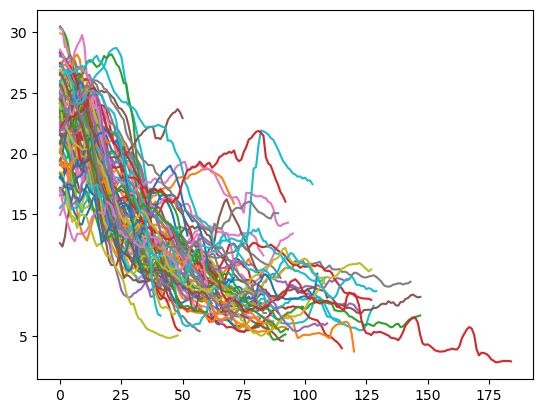

73 has 185 steps
185 6 74.62637362637362


In [30]:
storms = range(0,len(y[:,0]))
for storm in storms:
    plt.plot(y[storm,:])
plt.show()

steps_y = []
for storm in storms:
    timesteps_array = y[storm,:]

# Find the indices where the array is NaN
    nan_indices = np.where(np.isnan(y[storm,:]))[0]

# Initialize the list to store last steps before NaN
    last_steps_before_nan = []

# Iterate through the indices of NaN values to find the previous step
    try:
        for nan_index in nan_indices:
            if nan_index > 0:  # Ensure there's a previous element
                    last_steps_before_nan.append(timesteps_array[nan_index - 1])
            else:
                print(storm, 'has 185 steps')
        # Print the result
        #print("Timesteps:", timesteps)
        #print("Last steps before NaN:", last_steps_before_nan[0],' at steps:',nan_indices[0])
        steps_y.append(nan_indices[0])
    except:
         print(storm, 'has 185 steps')
         steps_y.append(185)
print(np.max(steps_y), np.min(steps_y), np.mean(steps_y))

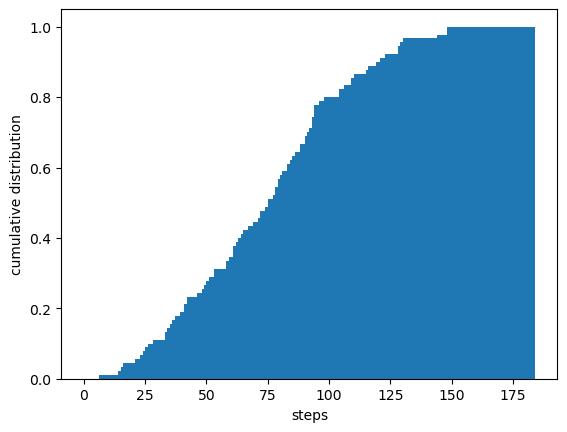

In [33]:
# see the cumulative distribution of the steps

plt.hist(steps_y, bins=range(0,185,1), cumulative=True, density=True)
plt.xlabel('steps')
plt.ylabel('cumulative distribution')
plt.show()


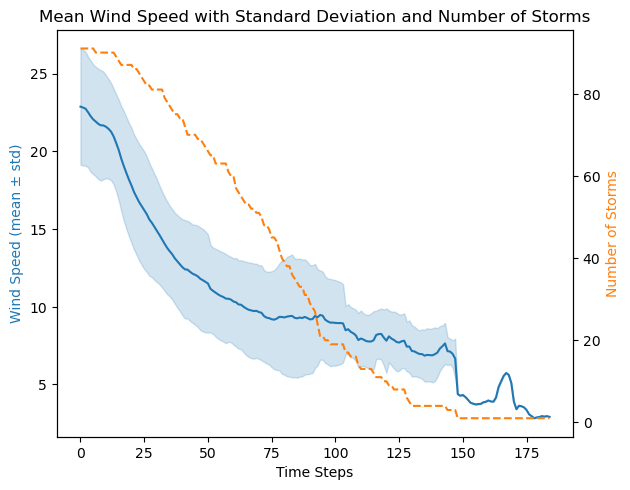

In [34]:
# Calculate mean and standard deviation ignoring NaNs
mean_wind_speed = np.nanmean(y, axis=0)
std_wind_speed = np.nanstd(y, axis=0)

# Calculate the number of storms at each time step
num_storms = np.sum(~np.isnan(y), axis=0)

# Plot mean wind speed with error bars
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wind Speed (mean ± std)', color='tab:blue')
ax1.plot(mean_wind_speed, color='tab:blue')
ax1.fill_between(range(len(mean_wind_speed)), mean_wind_speed - std_wind_speed, mean_wind_speed + std_wind_speed, color='tab:blue', alpha=0.2)

# Create a second y-axis to plot the number of storms
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Storms', color='tab:orange')
ax2.plot(num_storms, color='tab:orange', linestyle='dashed')

fig.tight_layout()  # Adjust layout to make room for both y-axes
plt.title('Mean Wind Speed with Standard Deviation and Number of Storms')
plt.show()

In [42]:
y_pd = pd.DataFrame(y).T
y_pd.describe()

0          1          2          3           4          5   \
count  104.000000  79.000000  88.000000  78.000000  119.000000  69.000000   
mean    14.163377  15.356874  11.275176  11.506153   11.435814  16.120705   
std      6.121512   4.497478   4.221458   4.305703    4.866715   6.356280   
min      7.693137  10.172260   5.520400   6.165390    6.600149   6.562311   
25%      8.697013  11.359505   8.064486   7.598319    8.154141  11.119914   
50%     10.931401  13.631405  10.252935  10.395060    9.255024  12.724149   
75%     18.073857  18.444467  13.312890  15.274535   13.018780  23.185293   
max     26.870548  24.300875  19.978590  19.470783   25.978980  26.134373   

              6           7          8           9   ...         81  \
count  84.000000  144.000000  80.000000  129.000000  ...   6.000000   
mean   15.005116   13.790097  12.051851   13.275753  ...  19.115931   
std     5.821829    5.922897   3.949502    7.632248  ...   0.196928   
min     9.631534    7.607120   6.767526    5.474651  ...  18.862299   
25%    11.356457    9.825318   8.215969    6.633318  ...  18.992523   
50%    13.257914   10.838455  12.127885    9.962238  ...  19.084203   
75%    13.843831   16.323114  14.832895   21.169485  ...  19.281141   
max    29.742474   27.805250  20.658800   28.685165  ...  19.356130   

              82         83         84         85         86         87  \
count  67.000000  93.000000  28.000000  46.000000  61.000000  81.000000   
mean   16.075268  19.869509  21.379788  15.221374  13.189253  14.647200   
std     4.265895   2.467331   4.131524   6.270609   1.599658   4.548091   
min     9.449133  15.962175  13.215379   8.769377   9.242438   8.866925   
25%    12.629088  17.975826  18.965212   9.545362  12.315668  12.306776   
50%    15.646660  19.596052  22.837212  13.343618  13.078282  12.775018   
75%    17.516758  21.708612  24.661313  20.528772  14.122043  15.216626   
max    23.847490  25.366272  25.229431  26.605291  17.071308  24.836071   

              88         89         90  
count  49.000000  42.000000  24.000000  
mean   10.075560  20.447926  15.735202  
std     4.297714   6.089810   1.747074  
min     4.840532   6.679406  12.620432  
25%     5.528109  16.278029  13.833893  
50%    10.212911  23.618547  16.378704  
75%    13.876579  24.939112  17.108898  
max    18.466738  27.284231  18.006823  

[8 rows x 91 columns]

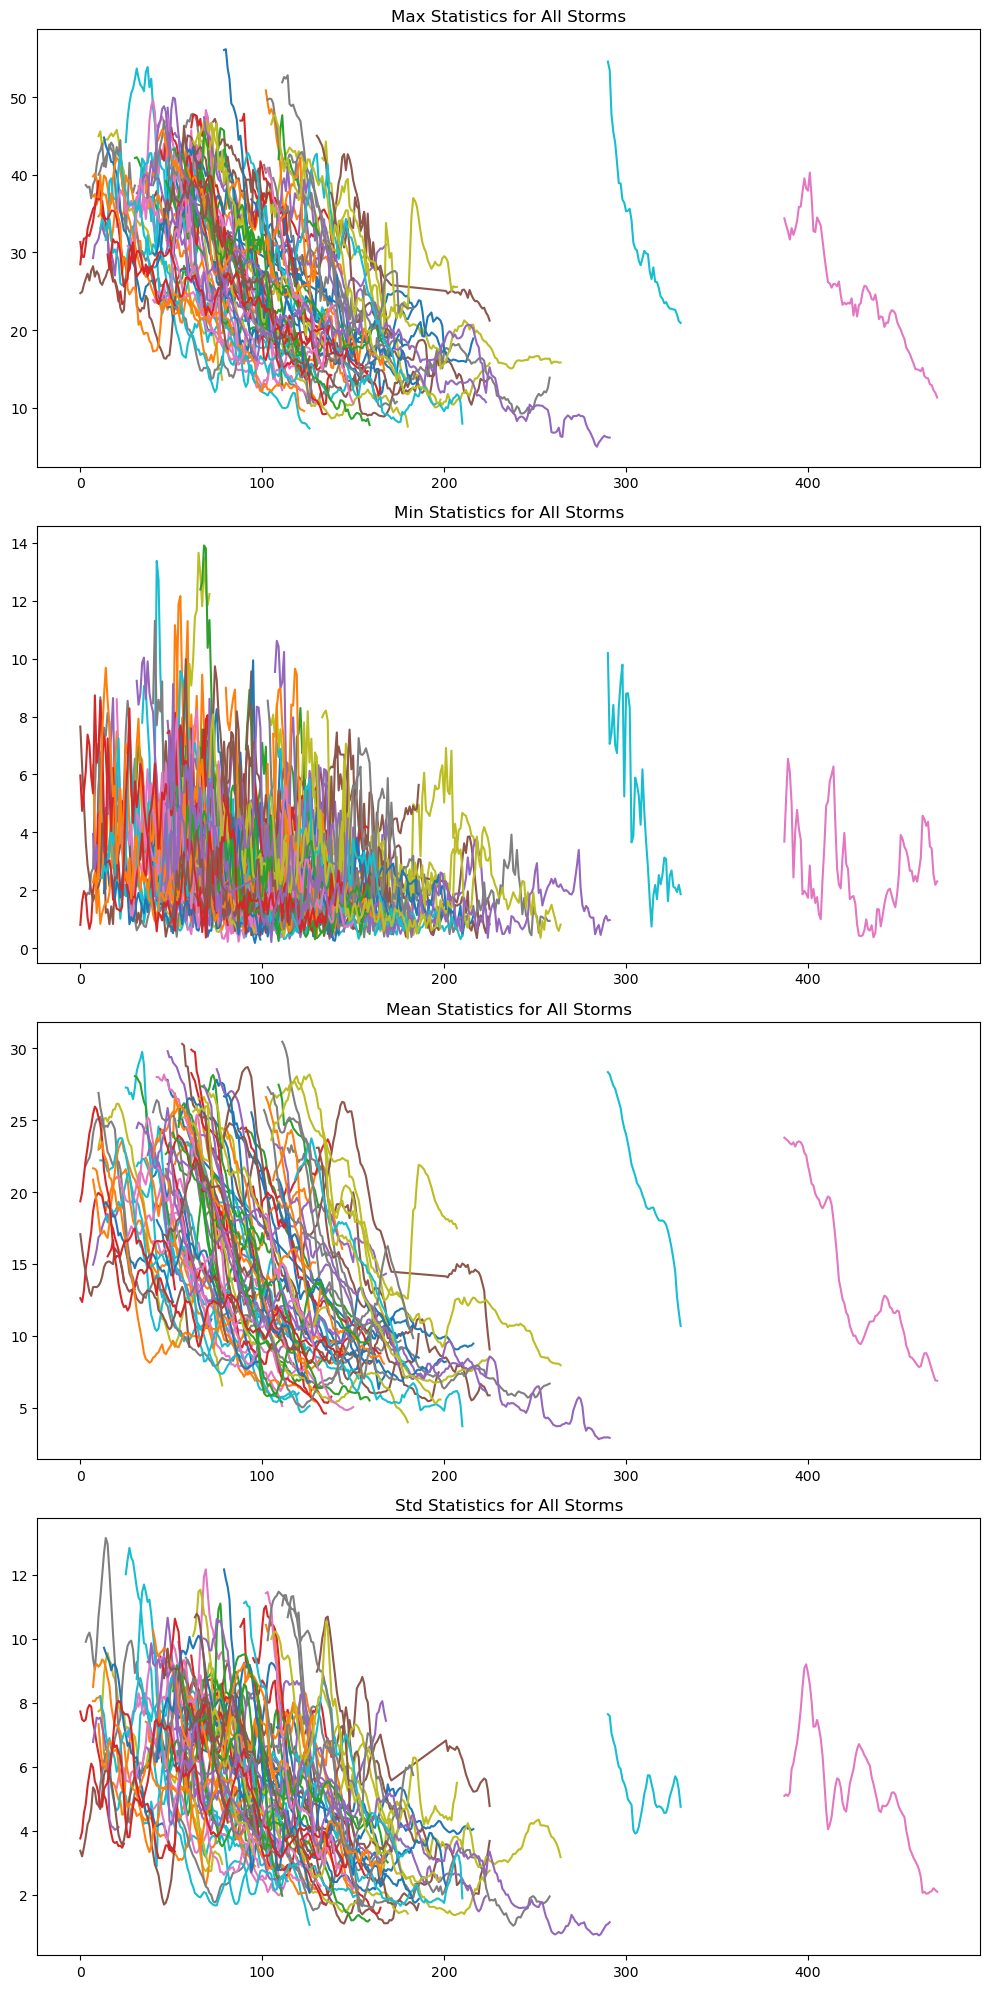

In [76]:
storms = range(1,97)
stats = ['max','min','mean','std']
path = '/Users/fabienaugsburger/Documents/GitHub/master-project/DATASETS/datasets_1h_EU/instantaneous_10m_wind_gust'
storm_data = {}

for storm in storms:
    storm_data[f'storm_{storm}'] = {}
    for stat in stats:
        storm_data[f'storm_{storm}'][stat] = pd.read_csv(f'{path}/storm_{storm}/{stat}_{storm}_0.csv', index_col=0)
        #try:
            #del locals()[f'storm_{storm}']
        #except:
            #pass

# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot each statistic on its own subplot
for storm in storms:
    axs[0].plot(storm_data[f'storm_{storm}']['max'], label=f'Storm {storm}')
    axs[1].plot(storm_data[f'storm_{storm}']['min'], label=f'Storm {storm}')
    axs[2].plot(storm_data[f'storm_{storm}']['mean'], label=f'Storm {storm}')
    axs[3].plot(storm_data[f'storm_{storm}']['std'], label=f'Storm {storm}')

# Set titles and legends for each subplot
axs[0].set_title('Max Statistics for All Storms')
#axs[0].legend(loc='upper right', fontsize='small', ncol=2)

axs[1].set_title('Min Statistics for All Storms')
#axs[1].legend(loc='upper right', fontsize='small', ncol=2)

axs[2].set_title('Mean Statistics for All Storms')
#axs[2].legend(loc='upper right', fontsize='small', ncol=2)

axs[3].set_title('Std Statistics for All Storms')
#axs[3].legend(loc='upper right', fontsize='small', ncol=2)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



In [77]:
'''import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example dictionary structure for features and target (replace with actual data)
features_dict = {
    'storm_1': {
        'temperature': {
            'max': np.random.rand(185).tolist(),
            'min': np.random.rand(185).tolist(),
            'mean': np.random.rand(185).tolist(),
            'std': np.random.rand(185).tolist(),
        },
        'pressure': {
            'max': np.random.rand(185).tolist(),
            'min': np.random.rand(185).tolist(),
            'mean': np.random.rand(185).tolist(),
            'std': np.random.rand(185).tolist(),
        },
        # Add more features as needed
    },
    # Add more storms as needed
}

target_dict = {
    'storm_1': {
        'gust_wind': {
            'max': np.random.rand(185).tolist(),
            'min': np.random.rand(185).tolist(),
            'mean': np.random.rand(185).tolist(),
            'std': np.random.rand(185).tolist(),
        }
    },
    # Add more storms as needed
}

# Number of features
num_features = len(features_dict['storm_1'])
# Number of statistics
num_stats = 4

# Prepare the input feature array
X_list = []
for storm in features_dict.keys():
    feature_array = []
    for feature in features_dict[storm].keys():
        for stat in ['max', 'min', 'mean', 'std']:
            feature_array.append(features_dict[storm][feature][stat])
    X_list.append(np.array(feature_array).T)

# Prepare the target array
y_list = []
for storm in target_dict.keys():
    target_array = []
    for stat in ['max', 'min', 'mean', 'std']:
        target_array.append(target_dict[storm]['gust_wind'][stat])
    y_list.append(np.array(target_array).T)

# Convert lists to numpy arrays
X = np.array(X_list)
y = np.array(y_list)

# Ensure the shape is [samples, time steps, features]
print(X.shape)  # Should be (97, 185, 364)
print(y.shape)  # Should be (97, 185, 4)'''

(1, 185, 8)
(1, 185, 4)


In [80]:
import numpy as np
import pandas as pd

# Dataset
operating_system = 'mac'
if operating_system == 'win':
    path = 'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    path = '/Users/fabienaugsburger/Documents/GitHub/master-project/'
dataset = 'datasets_1h_EU'

if dataset == 'datasets_1h' or dataset == 'datasets_1h_EU':
    col_max = '1_hour_steps'
else:
    col_max = '3_hour_steps'

name_of_variables = pd.read_csv(f'{path}variable_list_24_v5.csv')

max_time_steps = pd.read_csv(f'{path}tracks_square_storm/storms_with_steps_and_index_ordered.csv',
                             delimiter=';', index_col=0)
if dataset == 'datasets_1h' or dataset == 'datasets_1h_EU':
    max_time_steps = 185
else:
    max_time_steps = 62
#max_time_steps = 185 # max_time_steps[col_max].max()+1

def split_variable_level(variable_with_level):
    parts = variable_with_level.rsplit('_', 1)
    if len(parts) == 2 and parts[1].isdigit():
        return parts[0], parts[1]
    else:
        return variable_with_level, 0

# Initialize the list to hold the data for each storm
data_list = []
data_list_y = []

stats = ['max', 'min', 'mean', 'std']

for storm_idx in range(1,97):
    storm_data = []
    storm_data_y = []
    for var_name, row in name_of_variables.iterrows():
        var_name = split_variable_level(row['variables'])[0]
        level = split_variable_level(row['variables'])[1]
        if var_name == 'instantaneous_10m_wind_gust':
            try:
                for stat in stats:
                    df = pd.read_csv(f'{path}/DATASETS/{dataset}/{var_name}/storm_{storm_idx}/{stat}_{storm_idx}_{level}.csv') #locals()[f'mean_{var_name}_{level}']
                    if df.shape[0] > 0:  # Check if the csv is not empty
                        storm_series = df.loc[:, '0'].values
                        storm_data_y.append(storm_series)
                    else:
                        print(f"Storm {storm_idx} not found in {var_name} for level {level}")
                        storm_data_y.append(np.array([]))  # Append an empty array if the storm index does not exist
            except KeyError:
                storm_data_y.append(np.array([]))  # Append an empty array if the variable is not found
        else:
            try:
                for stat in stats:
                    df = pd.read_csv(f'{path}/DATASETS/{dataset}/{var_name}/storm_{storm_idx}/{stat}_{storm_idx}_{level}.csv') #locals()[f'mean_{var_name}_{level}']
                    if df.shape[0] > 0:  # Check if the csv is not empty
                        storm_series = df.loc[:, '0'].values
                        storm_data.append(storm_series)
                    else:
                        print(f"Storm {storm_idx} not found in {var_name} for level {level}")
                        storm_data.append(np.array([]))  # Append an empty array if the storm index does not exist
            except KeyError:
                storm_data.append(np.array([]))  # Append an empty array if the variable is not found

        # Find the maximum length of time steps for the current storm
        #max_time_steps = max(len(series) for series in storm_data)

    # Pad the data to have the same length of time steps
    storm_data_padded = [np.pad(series, (0, max_time_steps - len(series)), 'constant', constant_values=np.nan) for series in storm_data]
    storm_data_padded_y = [np.pad(series, (0, max_time_steps - len(series)), 'constant', constant_values=np.nan) for series in storm_data_y]

    #storm_data_padded = []
    #for series in storm_data:
    #    padded_series = np.pad(series, (0, max_time_steps - len(series)), 'constant', constant_values=np.nan)
    #    storm_data_padded.append(padded_series)

    # Stack the variables together and add to the list
    data_list.append(np.stack(storm_data_padded, axis=1))
    data_list_y.append(np.stack(storm_data_padded_y, axis=1))

# Convert the list to a 3D numpy array
X_all_3d = np.stack(data_list, axis=0)
y_all_3d = np.stack(data_list_y, axis=0)

print("Shape of the X 3D ndarray:", X_all_3d.shape)
print("Shape of the y 3D ndarray:", y_all_3d.shape)

Storm 91 not found in 10m_u_component_of_wind for level 0
Storm 91 not found in 10m_u_component_of_wind for level 0
Storm 91 not found in 10m_u_component_of_wind for level 0
Storm 91 not found in 10m_u_component_of_wind for level 0
Storm 91 not found in 10m_v_component_of_wind for level 0
Storm 91 not found in 10m_v_component_of_wind for level 0
Storm 91 not found in 10m_v_component_of_wind for level 0
Storm 91 not found in 10m_v_component_of_wind for level 0
Storm 91 not found in 2m_dewpoint_temperature for level 0
Storm 91 not found in 2m_dewpoint_temperature for level 0
Storm 91 not found in 2m_dewpoint_temperature for level 0
Storm 91 not found in 2m_dewpoint_temperature for level 0
Storm 91 not found in 2m_temperature for level 0
Storm 91 not found in 2m_temperature for level 0
Storm 91 not found in 2m_temperature for level 0
Storm 91 not found in 2m_temperature for level 0
Storm 91 not found in convective_available_potential_energy for level 0
Storm 91 not found in convective_ava

In [81]:
# check if storms in tracks_1h_EU are continuous with the column timestep
index_storm_EU = []
for i in range(0, 96):
    locals()[f'storm_{i+1}'] = pd.read_csv(f'{path}tracks_square_storm/ALL_TRACKS/tracks_1h_EU/storm_{i+1}.csv')
    try:
        if locals()[f'storm_{i+1}']['timestep'].values.max() -locals()[f'storm_{i+1}']['timestep'].values.min() == len(locals()[f'storm_{i+1}'])-1:
            print(f'Storm {i} is continuous.')
            index_storm_EU.append(i)
        else:
            print(f'Storm {i} is not continuous.')
    except ValueError:
        print(f'Storm {i} is empty.')

Storm 0 is not continuous.
Storm 1 is continuous.
Storm 2 is continuous.
Storm 3 is continuous.
Storm 4 is continuous.
Storm 5 is continuous.
Storm 6 is continuous.
Storm 7 is continuous.
Storm 8 is continuous.
Storm 9 is continuous.
Storm 10 is continuous.
Storm 11 is continuous.
Storm 12 is continuous.
Storm 13 is continuous.
Storm 14 is continuous.
Storm 15 is continuous.
Storm 16 is continuous.
Storm 17 is continuous.
Storm 18 is continuous.
Storm 19 is continuous.
Storm 20 is continuous.
Storm 21 is continuous.
Storm 22 is continuous.
Storm 23 is continuous.
Storm 24 is continuous.
Storm 25 is not continuous.
Storm 26 is continuous.
Storm 27 is continuous.
Storm 28 is continuous.
Storm 29 is continuous.
Storm 30 is continuous.
Storm 31 is continuous.
Storm 32 is continuous.
Storm 33 is continuous.
Storm 34 is not continuous.
Storm 35 is continuous.
Storm 36 is continuous.
Storm 37 is continuous.
Storm 38 is continuous.
Storm 39 is continuous.
Storm 40 is continuous.
Storm 41 is co

In [82]:
storm_index_test_valid = [0, 3, 4, 11, 13, 14, 17, 20, 25, 27, 28, 29, 31, 35, 53, 54, 57, 64, 69, 71, 75, 81, 85, 86, 87, 90, 92, 93, 95]
storm_index_validation = [3, 4, 11, 17, 31, 35, 54, 86, 87, 92]
storm_index_all = range(96)

# remove index of storm in the test set from the validation set

storm_index_test = [x for x in storm_index_test_valid if x not in storm_index_validation]

# remove index of storm in the valdation set from the test set

storm_index_validation = [x for x in storm_index_validation if x not in storm_index_test]

# remove index of storm in the training set from the validation set and validation set

storm_index_training = [x for x in storm_index_all if x not in storm_index_test_valid]

print(storm_index_validation, storm_index_test)
print(storm_index_training)

storm_index_training = [x for x in storm_index_training if x in index_storm_EU]
storm_index_validation = [x for x in storm_index_validation if x in index_storm_EU]
storm_index_test = [x for x in storm_index_test if x in index_storm_EU]

print("Validation indices:", storm_index_validation)
print("Test indices:", storm_index_test)
print("Training indices:", storm_index_training)

[3, 4, 11, 17, 31, 35, 54, 86, 87, 92] [0, 13, 14, 20, 25, 27, 28, 29, 53, 57, 64, 69, 71, 75, 81, 85, 90, 93, 95]
[1, 2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 18, 19, 21, 22, 23, 24, 26, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 88, 89, 91, 94]
Validation indices: [3, 4, 11, 17, 31, 35, 54, 86, 87, 92]
Test indices: [13, 14, 20, 27, 28, 29, 53, 57, 64, 69, 71, 75, 81, 85, 93, 95]
Training indices: [1, 2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 18, 19, 21, 22, 23, 24, 26, 30, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 88, 89, 91]


In [83]:
# extract the data for the test set and the validation set
#number_storms_EU =  range(len(index_storm_EU))

X_test = X_all_3d[storm_index_test,:,:]
X_validation = X_all_3d[storm_index_validation,:,:]
X_train = X_all_3d[storm_index_training,:,:]

y_test = y_all_3d[storm_index_test,:,:]
y_validation = y_all_3d[storm_index_validation,:,:]
y_train = y_all_3d[storm_index_training,:,:]

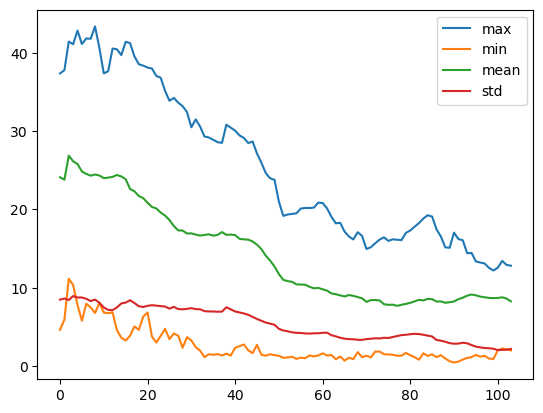

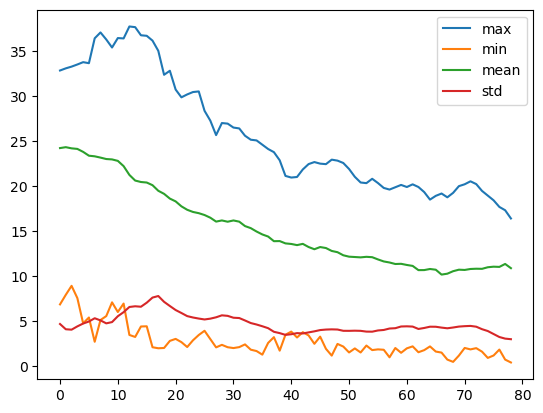

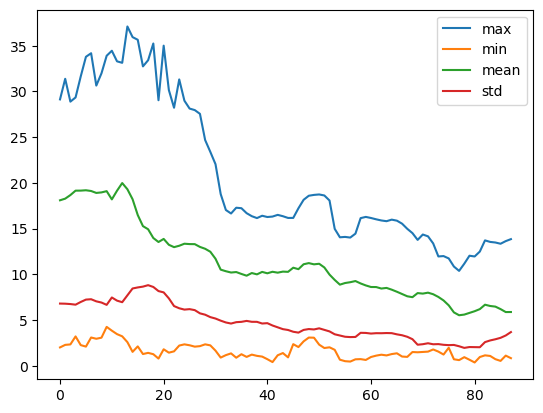

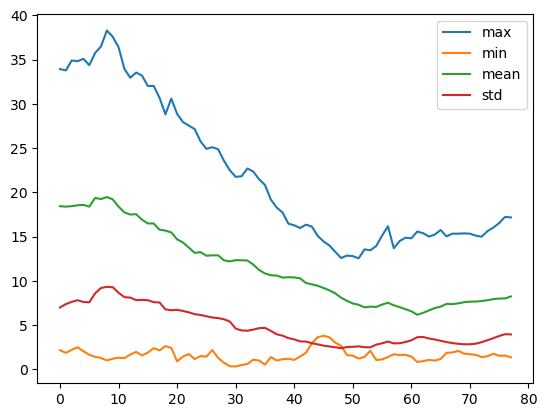

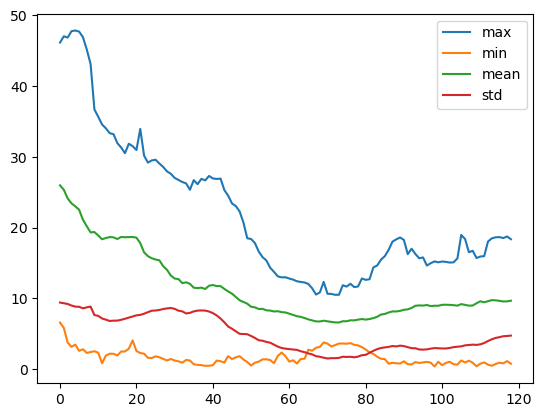

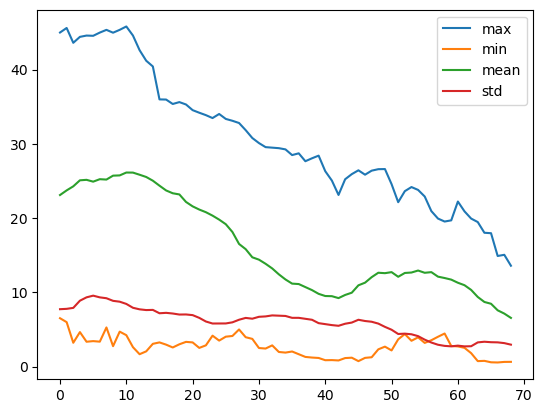

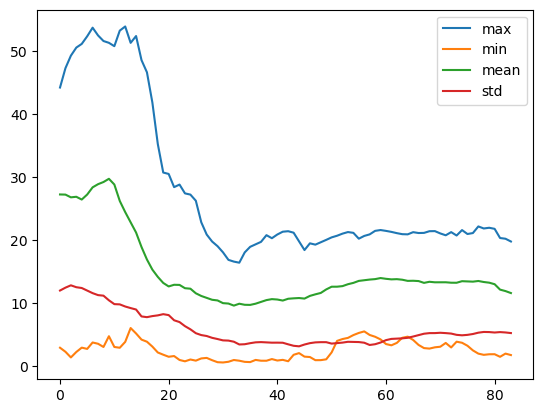

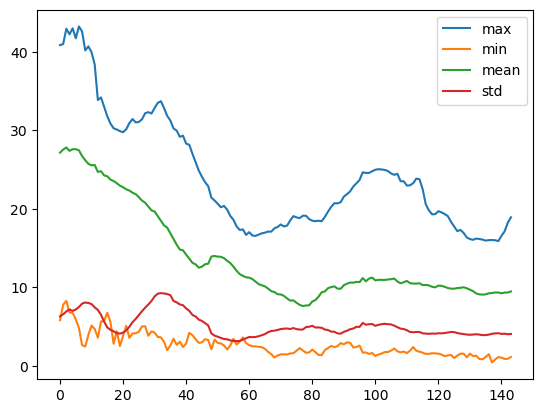

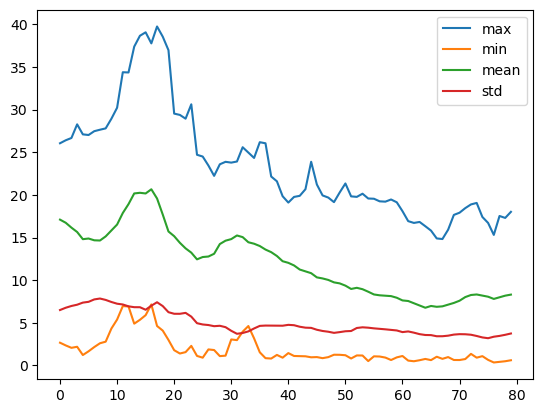

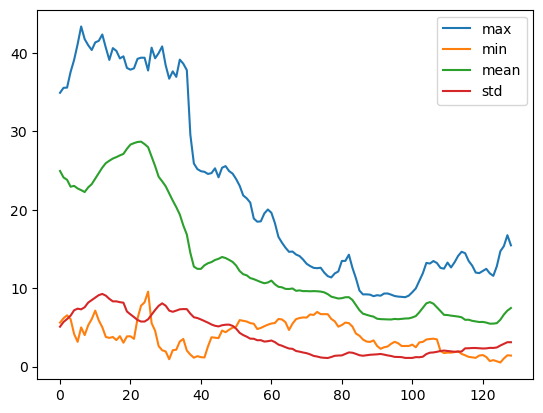

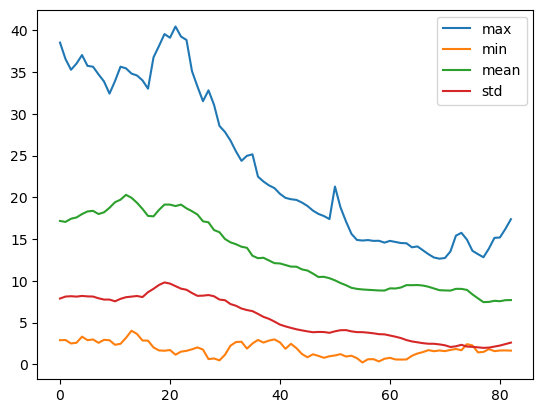

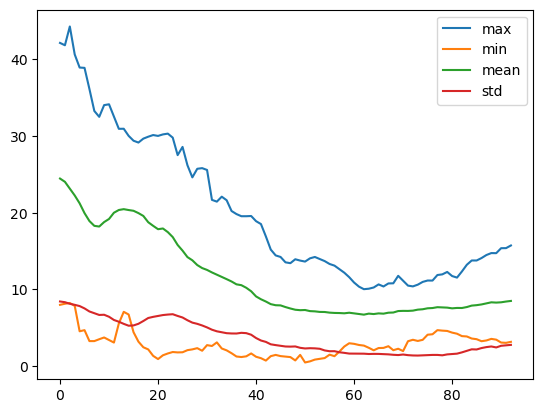

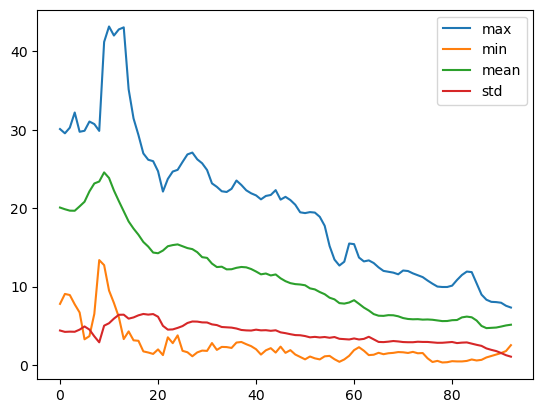

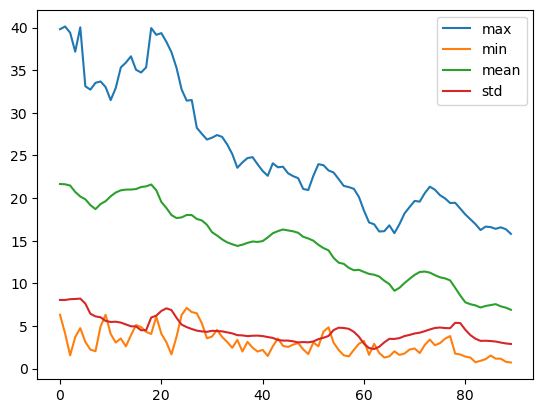

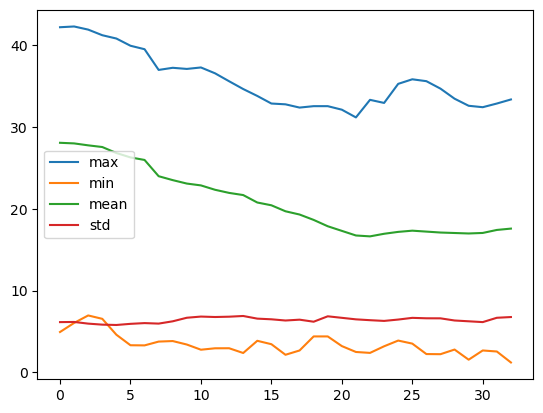

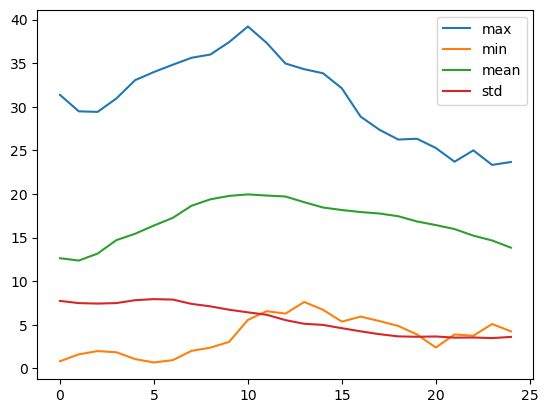

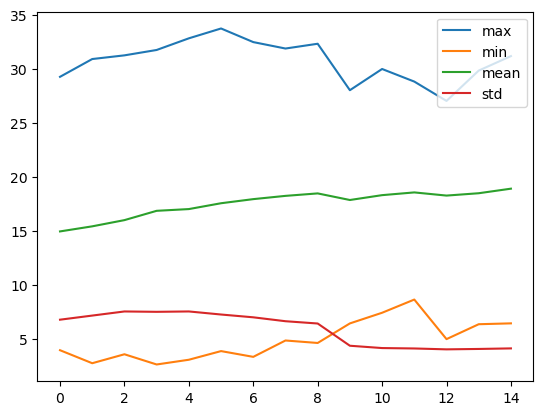

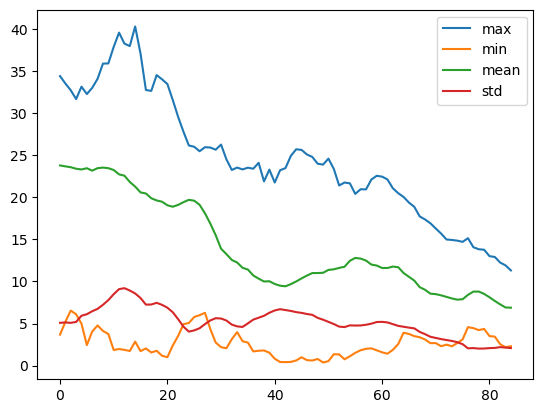

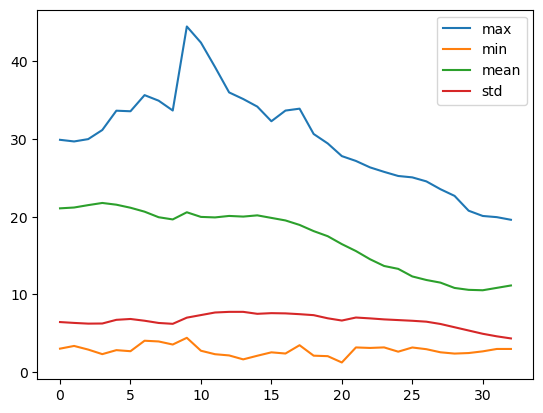

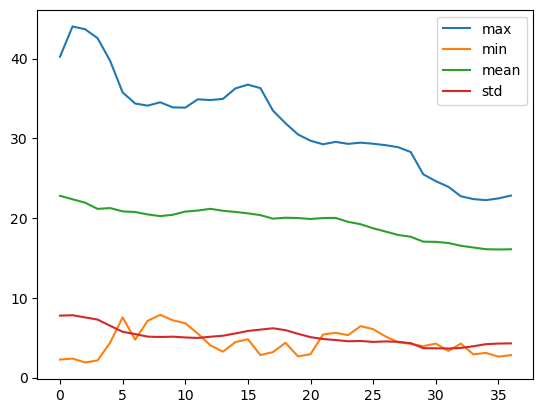

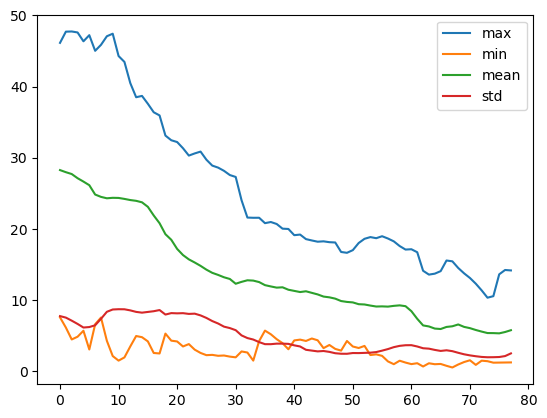

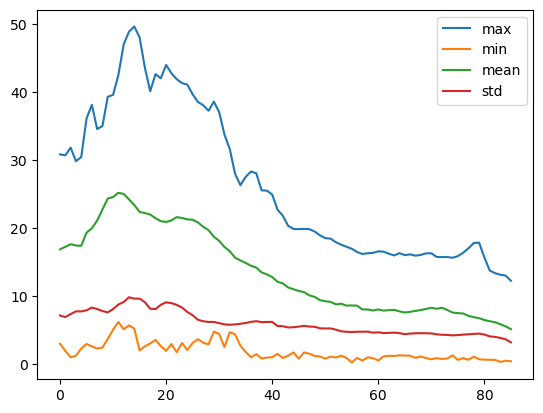

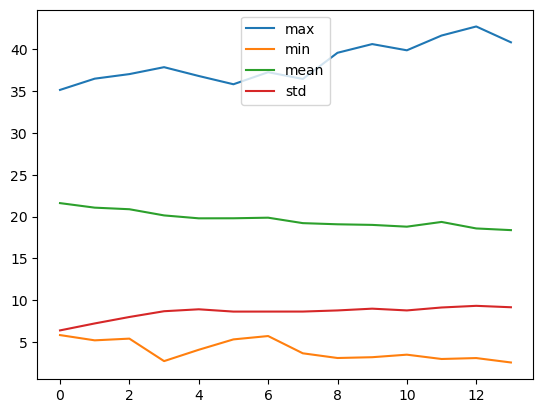

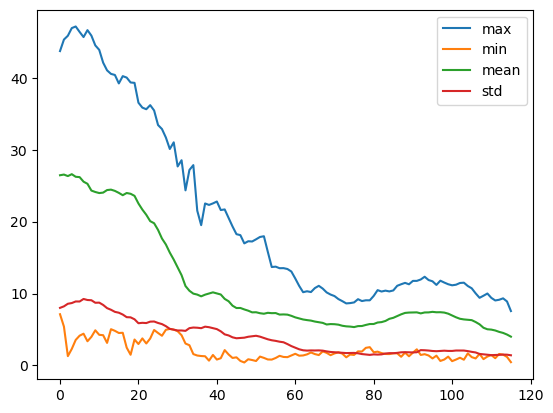

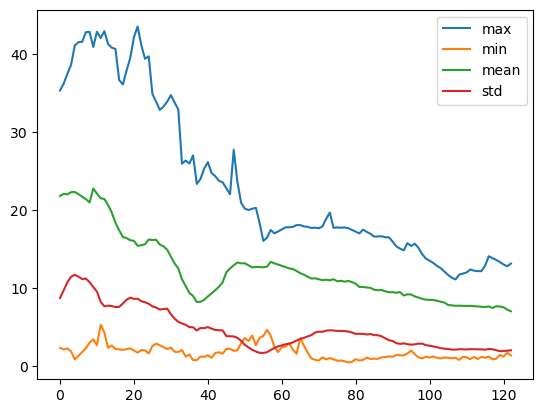

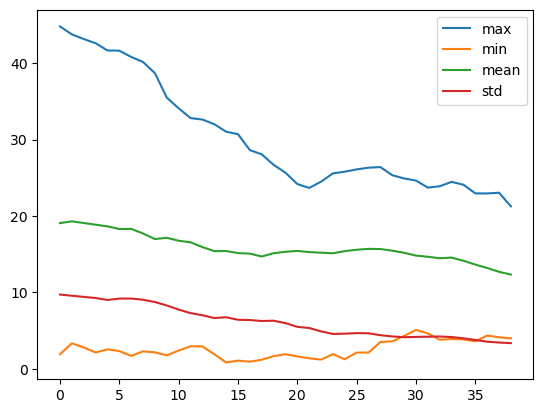

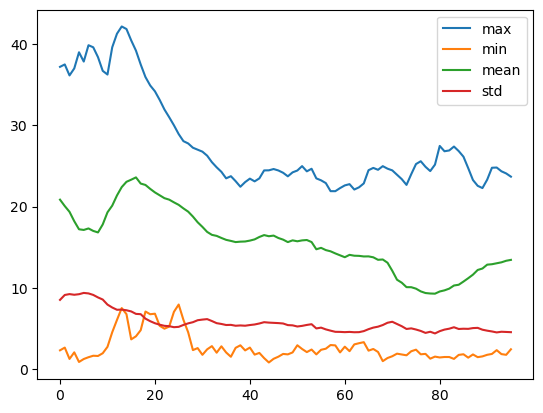

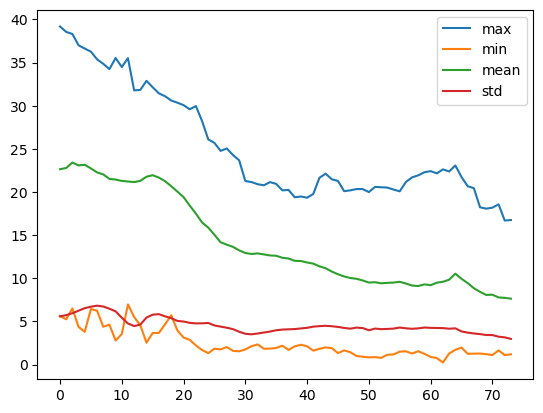

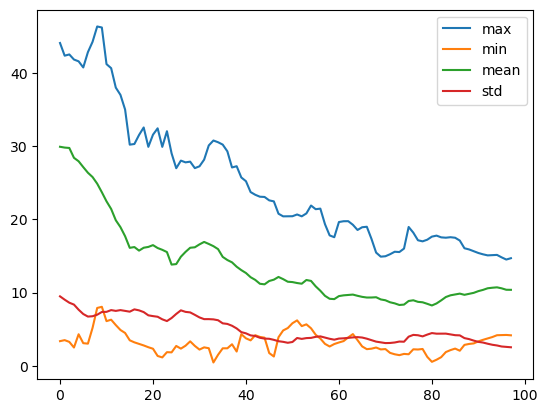

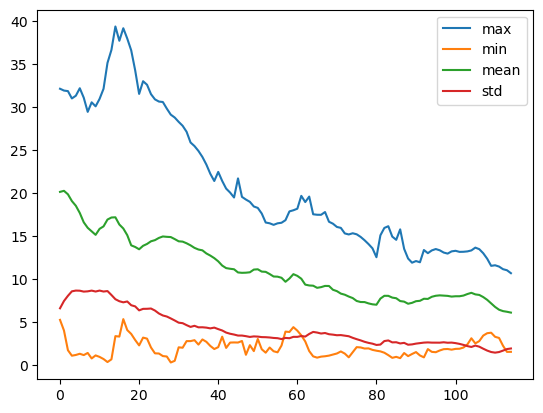

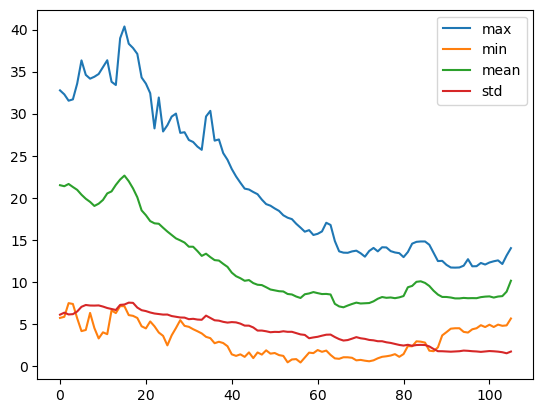

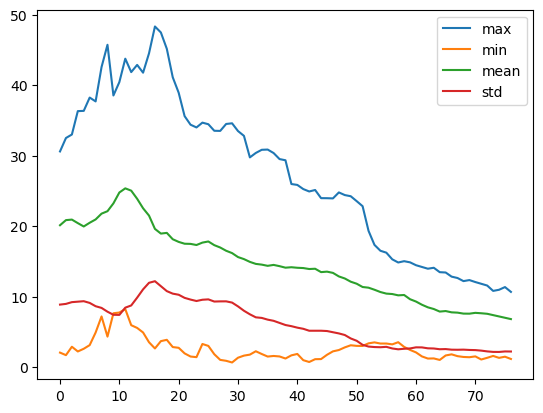

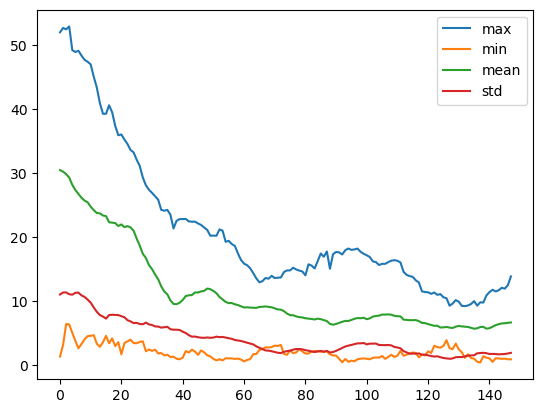

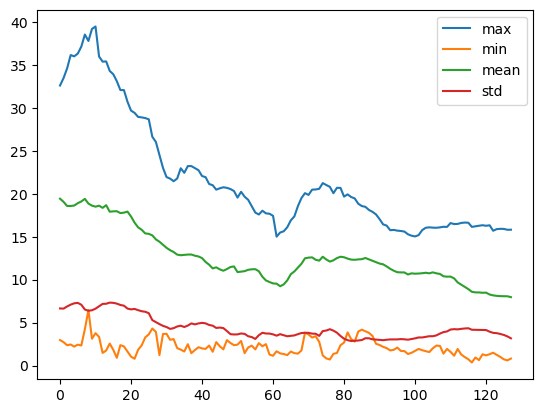

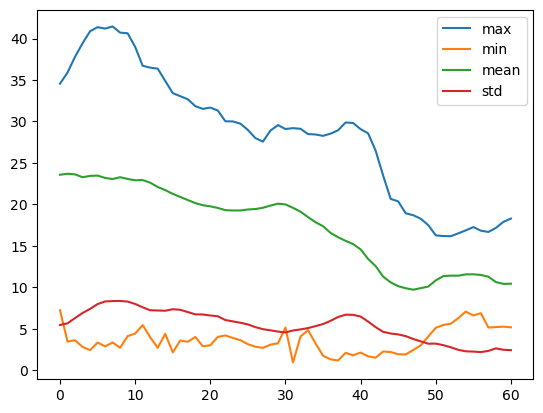

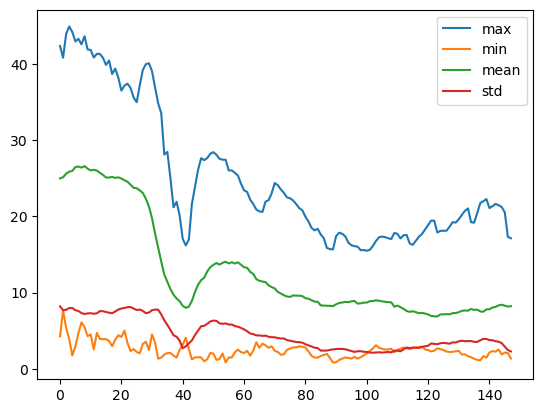

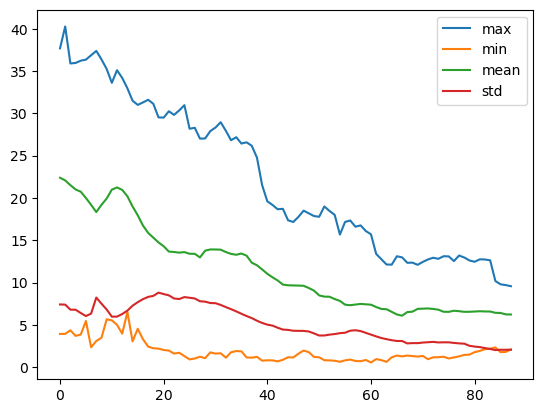

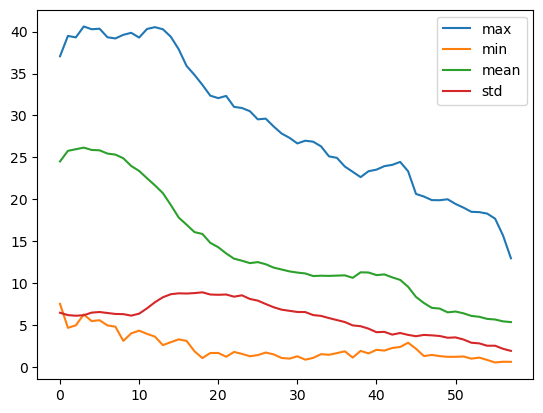

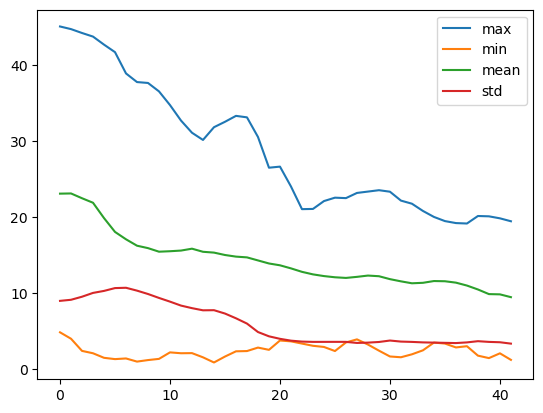

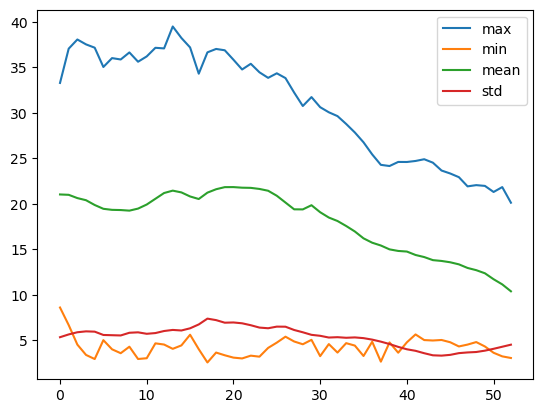

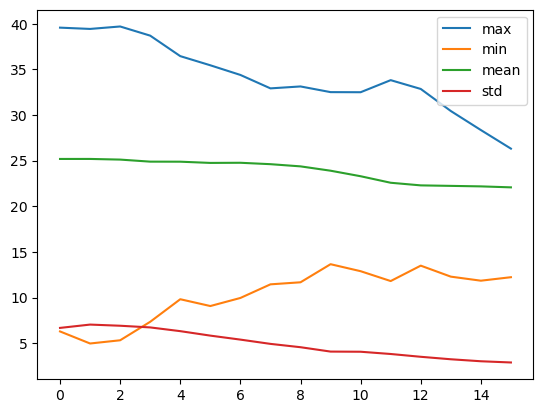

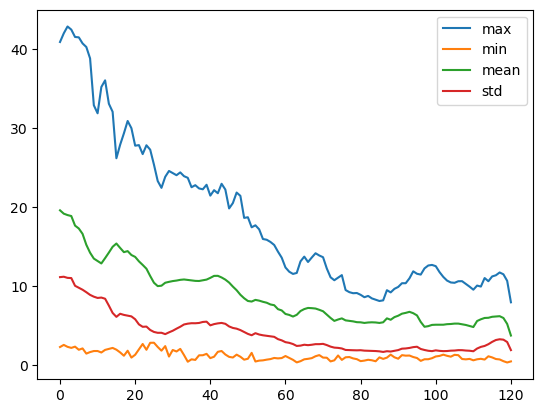

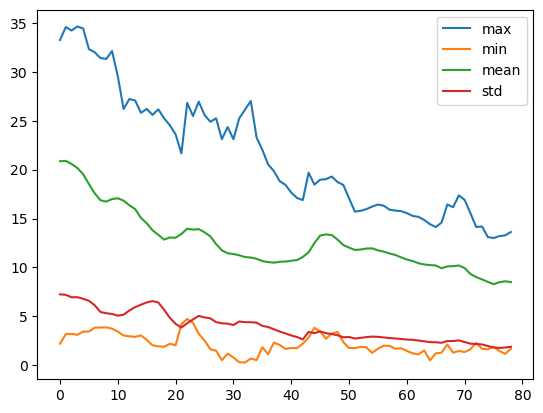

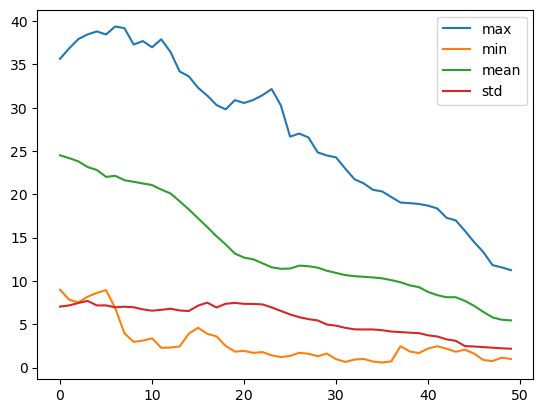

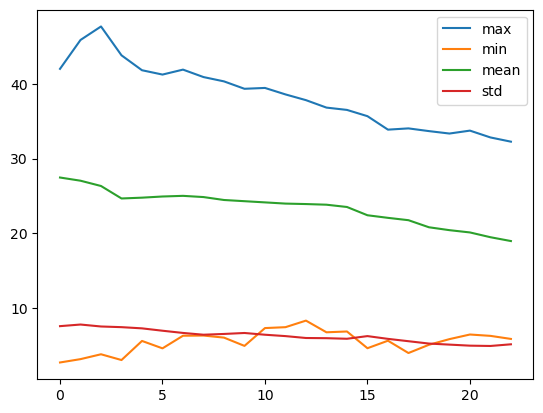

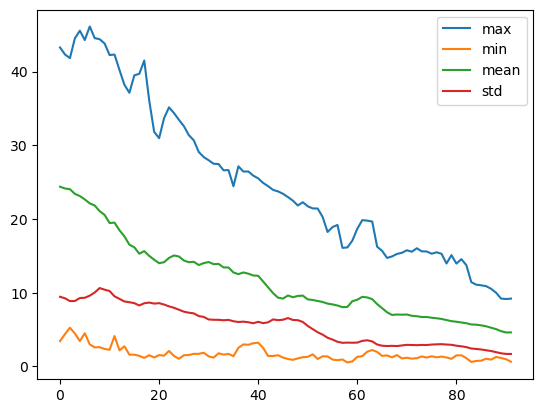

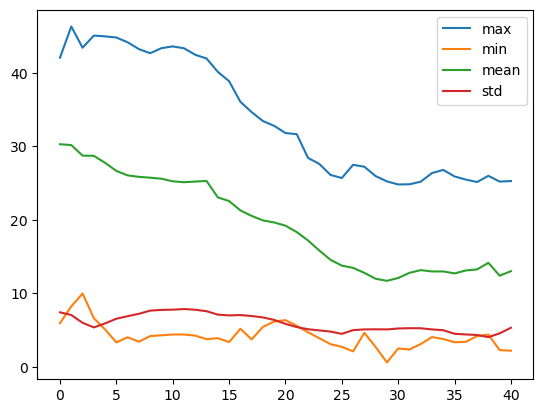

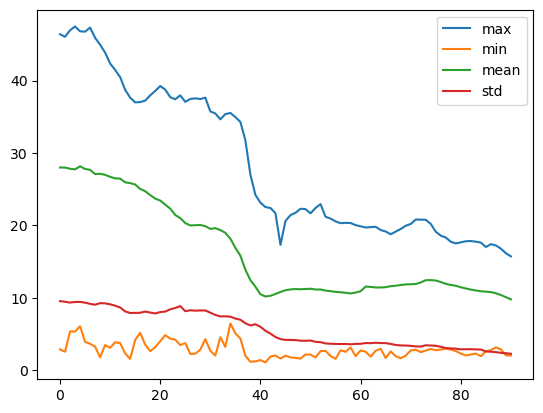

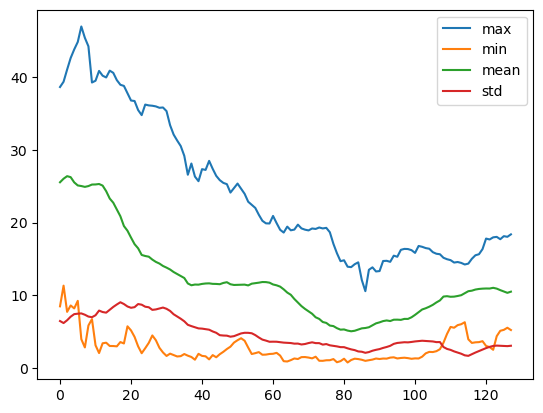

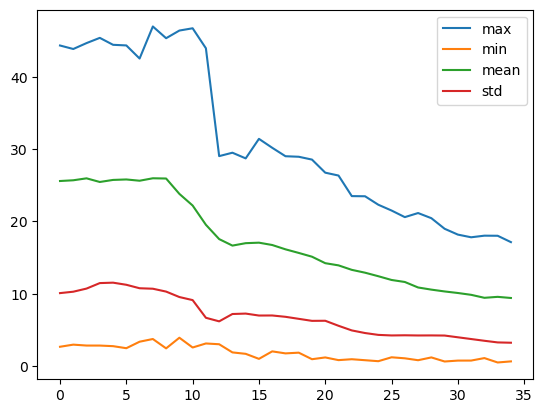

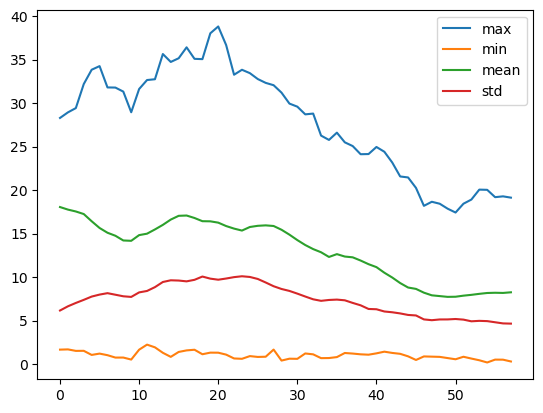

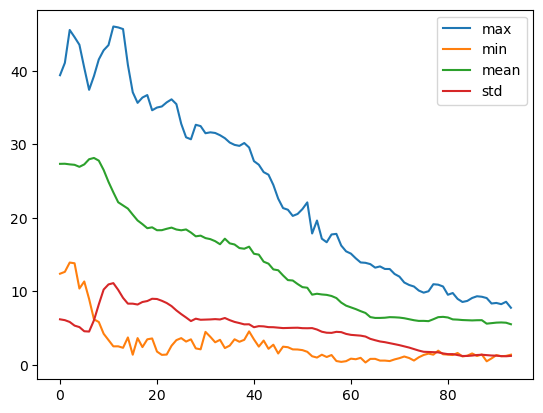

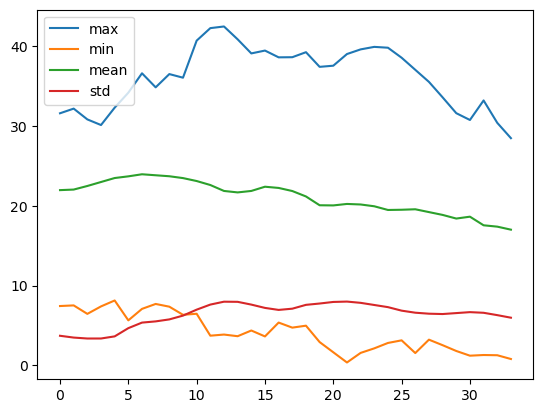

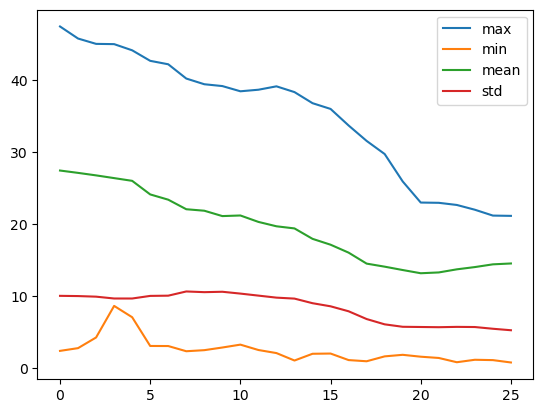

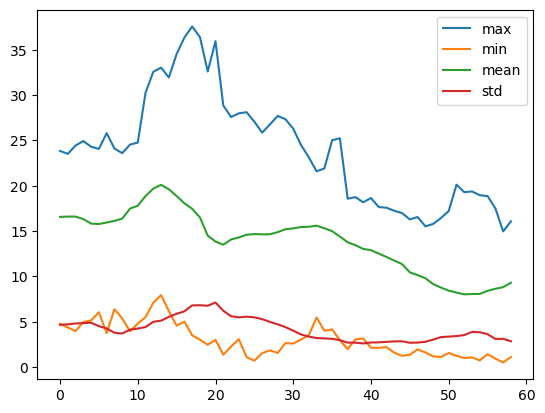

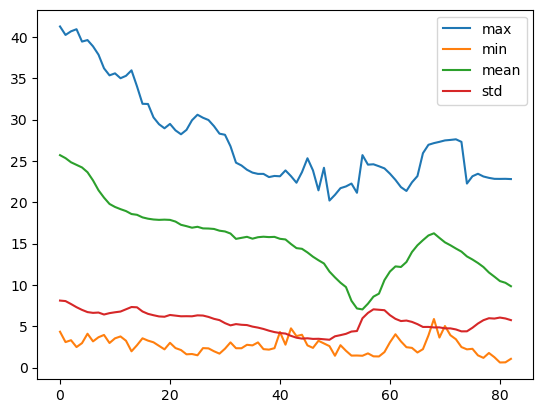

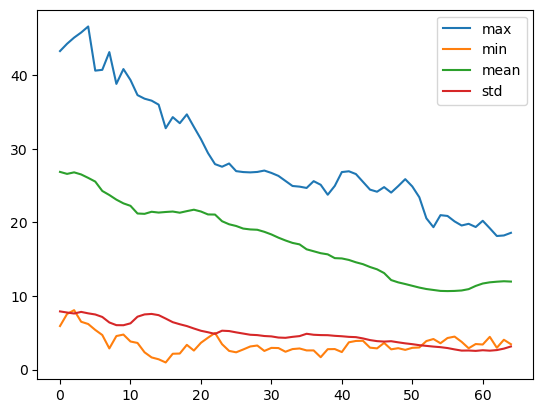

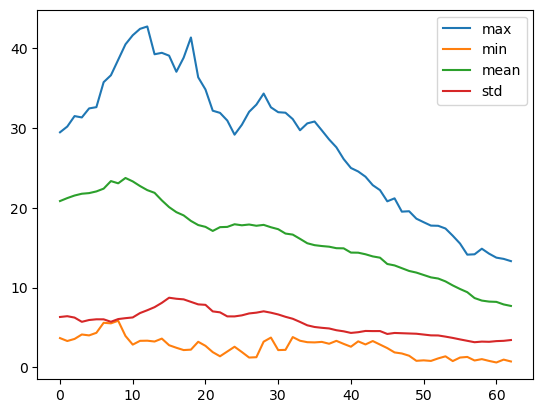

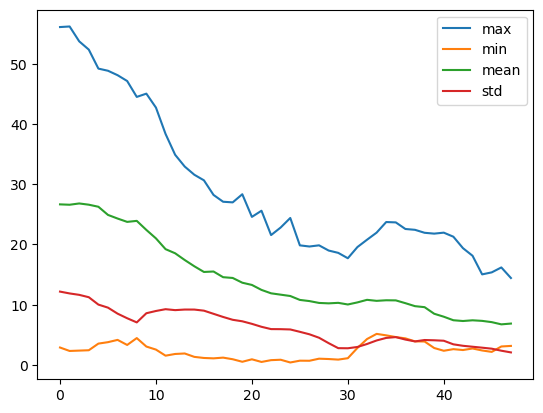

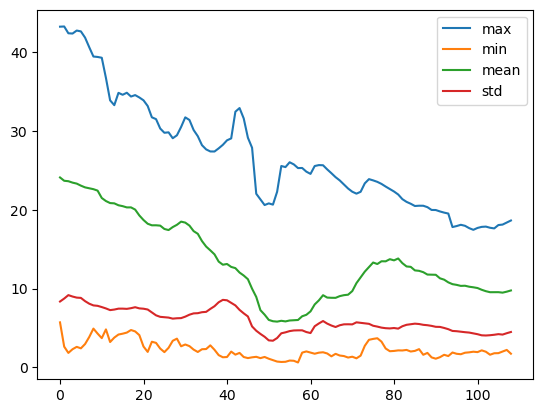

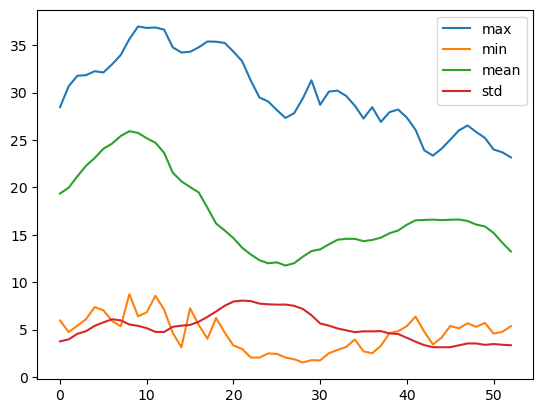

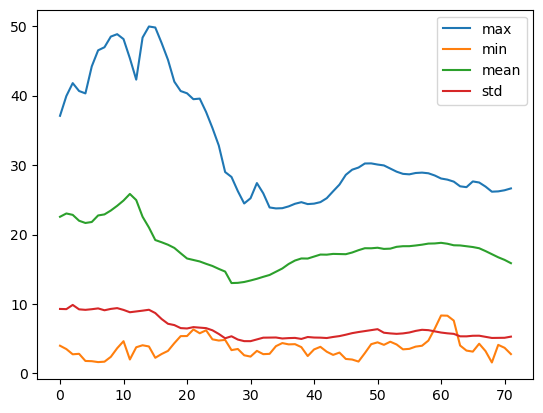

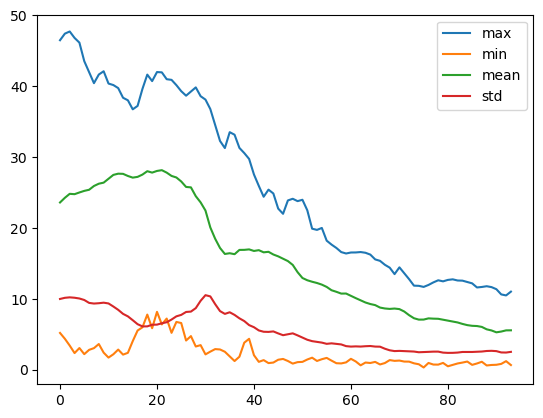

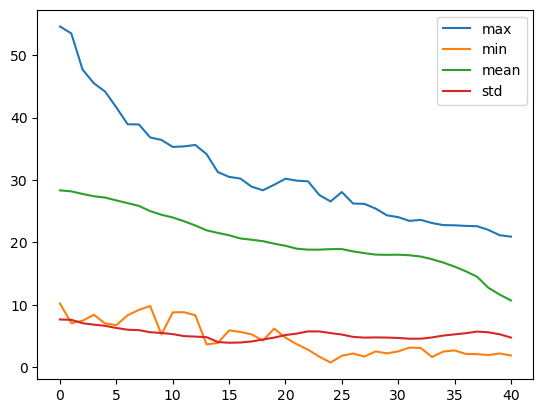

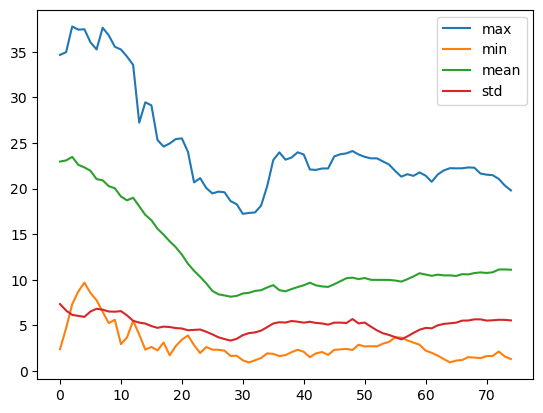

In [87]:
for i in range(0,len(y_train)):
    for j in range(4):
        plt.plot(y_train[i,:,j])
        plt.legend(['max','min','mean','std'])
    plt.show()

In [88]:
# save the data using numpy

if dataset == 'datasets_1h_EU':
    step = '1h'
else:
    step = '3h'

np.save(f'{path}DATASETS/X_y_EU_{step}/X_train_all_stat.npy', X_train)
np.save(f'{path}DATASETS/X_y_EU_{step}/X_validation_all_stat.npy', X_validation)
np.save(f'{path}DATASETS/X_y_EU_{step}/X_test_all_stat.npy', X_test)

np.save(f'{path}DATASETS/X_y_EU_{step}/y_train_all_stat.npy', y_train)
np.save(f'{path}DATASETS/X_y_EU_{step}/y_validation_all_stat.npy', y_validation)
np.save(f'{path}DATASETS/X_y_EU_{step}/y_test_all_stat.npy', y_test)